In [1]:
%%capture
!pip install pytorch-lightning

In [2]:
%%capture
!pip install lightning

In [3]:
%%capture
!pip install datasets

## T5 трансформер для перевода с немецкого на английский

Сегодня вы поработаете над настоящей задачей NLP и попробуете обучить трансформер переводить короткие предложения с английского на немецкий.

Токенизацию и блоки трансформера писать не придётся — будем пользоваться библиотекой `transformers`.

Наши задачи:
- Познакомиться с наиболее популярным методом токенизации текстов — byte pair encoding
- Научиться пользоваться токенизатором из `transformers`
- Подготовить даннные
- Обучить готовую архитектуру T5-small под нашу задачу
- Исследовать разные стратегии декодирования с помощью обученной модели

In [4]:
import math
from pathlib import Path
from typing import cast

import lightning as L
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

from datasets import load_dataset, load_from_disk

In [5]:
torch.manual_seed(42)

#### Готовим данные

In [6]:
%%capture
train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

In [7]:
train_dataset[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

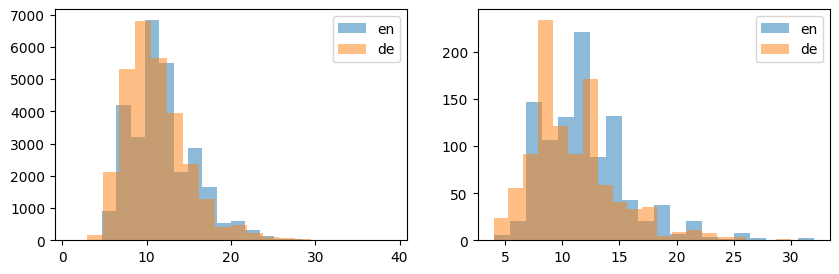

In [8]:
import matplotlib.pyplot as plt


def length_histogram(dataset, ax, bins=20) -> None:
    en_lengths = []
    de_lengths = []
    for sample in dataset:
        en_lengths.append(len(sample["en"].split(" ")))
        de_lengths.append(len(sample["de"].split(" ")))

    ax.hist(en_lengths, alpha=0.5, bins=bins, label="en")
    ax.hist(de_lengths, alpha=0.5, bins=bins, label="de")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
length_histogram(train_dataset, axes[0])
length_histogram(test_dataset, axes[1])

Оставим только сравнительно короткие предложения, чтобы можно было чему-то научиться за короткое время

In [9]:
maxlen = 8


def filter_dataset(dataset, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen
    ]


train_filtered = filter_dataset(train_dataset, maxlen)
test_filtered = filter_dataset(test_dataset, maxlen)

print(len(train_filtered), len(test_filtered))

5144 174


##### Токенизация: byte-pair encoding

Построение:

Начинаем со словаря, состоящего из отдельных символов (начальные токены).
На каждом шаге:
1. Оцениваем частоту всех пар токенов внутри слов, находим самую частую
2. Добавляем её в список токенов и в таблицу слияний
3. Останавливаемся, когда достигаем максимального размера словаря


Применение:

1. Разбиваем текст на символы
2. Находим первое возможное слияние в таблице и применяем его
3. Останавливаемся, когда дальнейшие слияния невозможны

<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif" style="background:white" height="300"/>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/bpe_apply.gif" style="background:white" height="300"/>


Реализаций много, мы будем использовать токенизатор  из библиотеки `transformers`, где помимо самого подготовленного токенизатора (`sentencepiece.SentencePieceProcessor`) много полезных методов для кодирования и декодирования.

Добавим при создании новый токен, который будет указывать на начало перевода

In [10]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(
    "t5-small", padding_size="right", bos_token="</b>", legacy=False
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [11]:
print("Размер словаря: ", len(tokenizer))

Размер словаря:  32101


Посмотрим на примеры токенов, в них встречаются и целые слова из разных языков, и числительные, и знаки препинания:

In [12]:
import random

random.choices(list(tokenizer.get_vocab().items()), k=10)

[('▁Entscheidung', 10798),
 ('▁perioada', 4584),
 ('205', 23201),
 ('▁versuchen', 21609),
 ('für', 7465),
 ('▁urmare', 10483),
 ('object', 30536),
 ('<extra_id_9>', 32090),
 ('▁aminti', 21507),
 ('▁Again', 7204)]

Токенизатор в работе: кодирование и декодирование предложений на немецком и английском:

In [13]:
encoded_german = tokenizer.encode(train_dataset[0]["de"])
encoded_english = tokenizer.encode(train_dataset[0]["en"])
print(encoded_german)
print(tokenizer.decode(encoded_german))
print(encoded_english)
print(tokenizer.decode(encoded_english))

[11280, 16815, 7838, 15, 16282, 436, 256, 8671, 35, 16, 74, 13271, 2221, 49, 21162, 3992, 5, 1]
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.</s>
[2759, 1021, 6, 1945, 5069, 7, 33, 1067, 1084, 186, 3, 30271, 5, 1]
Two young, White males are outside near many bushes.</s>


Об упаковке в батчи можно больше не беспокоиться — токенизатор умеет обрабатывать сразу пачку примеров

In [14]:
batch = [train_dataset[i]["en"] for i in range(4)]

encoded_batch = tokenizer.batch_encode_plus(
    batch, padding="longest", return_tensors="pt"
)
print(encoded_batch["input_ids"].shape)
print(encoded_batch.keys())

torch.Size([4, 19])
dict_keys(['input_ids', 'attention_mask'])


Возвращается два значения: `input_ids` — это наши токены, а `attention_mask` — это тензор, равный по размеру батчу токенов, где на месте `pad_token` стоят нули, в остальных позициях — единицы. Это нам понадобится потом.

А ещё можно кодировать сразу входные и выходные данные:

In [15]:
inputs = [train_dataset[i]["en"] + tokenizer.bos_token for i in range(4)]
targets = [train_dataset[i]["de"] for i in range(4)]

encoded_batch = tokenizer(
    inputs, text_target=targets, padding="longest", return_tensors="pt"
)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


Используем это в `collate_fn` для сборки батчей:

In [16]:
def collate_fn(
    tokenizer: T5Tokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    prompt = tokenizer.bos_token
    inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
    encoded_batch = tokenizer(
        inputs, text_target=targets, padding="longest", return_tensors="pt"
    )
    return encoded_batch

In [17]:
batch = [train_dataset[i] for i in range(4)]
encoded_batch = collate_fn(tokenizer, batch)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [18]:
print(encoded_batch["input_ids"].shape)
print(encoded_batch["attention_mask"].shape)
print(encoded_batch["labels"].shape)

torch.Size([4, 22])
torch.Size([4, 22])
torch.Size([4, 20])


Всё готово для получения минибатчей из датасетов:

In [19]:
train_loader = DataLoader(
    train_filtered,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)
test_loader = DataLoader(
    test_filtered,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)

#### Задание 1 (3 балла). DataModule

Реализуйте подкласс `lightning.LightningDataModule` для работы с обучающим и тестовым датасетами

In [20]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class Multi30kDataset(L.LightningDataModule):
    def __init__(self, maxlen: int = 0, batch_size: int = 32) -> None:
        super().__init__()
        self.maxlen = maxlen
        self.batch_size = batch_size
        self.tokenizer = T5Tokenizer.from_pretrained("t5-small", padding_size="right", bos_token="</b>", legacy=False)

    def setup(self, stage: str = None):
        self.train_dataset = self.filter_dataset(load_dataset("bentrevett/multi30k", split="train"))
        self.test_dataset = self.filter_dataset(load_dataset("bentrevett/multi30k", split="test"))

    def filter_dataset(self, dataset) -> list[dict[str, str]]:
        maxlen = self.maxlen
        return [
            dataset[i]
            for i in range(len(dataset))
            if len(dataset[i]["en"].split(" ")) <= maxlen
        ]

    def collate_fn(self, batch: list[tuple[str, str]]) -> tuple[Tensor, Tensor]:
        prompt = self.tokenizer.bos_token
        inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
        encoded_batch = self.tokenizer(
            inputs, text_target=targets, padding="longest", return_tensors="pt"
        )
        return encoded_batch

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return self.val_dataloader()

In [21]:
multi30k = Multi30kDataset(maxlen=8, batch_size=12)

#### Задание 2 (6 баллов). Обучение T5

paper: https://arxiv.org/abs/1910.10683

Обучите `t5-small` на наших данных, длительность обучения — на ваше усмотрение. В [документации](https://huggingface.co/docs/transformers/model_doc/t5) вы найдёте примеры использования, которые помогут вам разобраться в интерфейсе модели.

In [22]:
t5 = T5ForConditionalGeneration.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Обернём в `LightningModule`

In [24]:
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.optim import AdamW

class Seq2Seq(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        tokenizer: T5Tokenizer,
        lr: float = 0.01,
    ) -> None:
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr

    def training_step(self, batch: dict[str, torch.Tensor], batch_idx: int) -> STEP_OUTPUT:
        # outputs = self.model(**batch)
        outputs = self.model(input_ids=batch["input_ids"],
                             attention_mask=batch["attention_mask"],
                             labels=batch["labels"])
        loss = outputs.loss
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self) -> OptimizerLRScheduler:
        return AdamW(self.model.parameters(), lr=self.lr)

In [26]:
from lightning.pytorch.loggers import CSVLogger

trainer = L.Trainer(
    accelerator="auto", max_epochs=50, limit_train_batches=10, logger=CSVLogger("logs")
)

seq2seq = Seq2Seq(t5, multi30k.tokenizer, lr=0.001)

trainer.fit(model=seq2seq, datamodule=multi30k)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M | eval
------------------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Tot

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


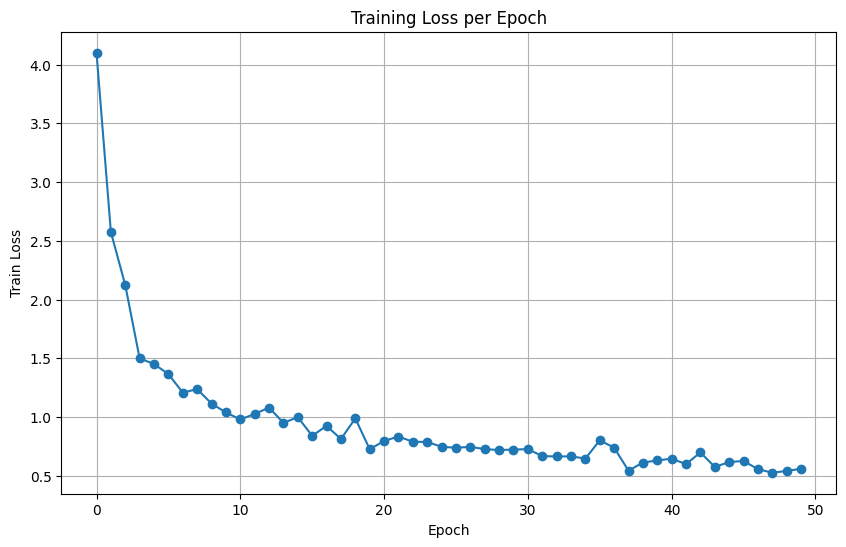

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

log_df = pd.read_csv('logs/lightning_logs/version_0/metrics.csv')

epoch_data = log_df[log_df['train_loss'].notna()].groupby('epoch')['train_loss'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(epoch_data['epoch'], epoch_data['train_loss'], marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)

plt.show()

#### Задание 3 (3 балла). Генерация перевода

Сгенерируйте перевод для одного батча из тестового датасета (используйте метод `t5.generate()`), используя разные стратегии декодирования:
- *greedy decoding*
- *multinomial sampling*
- *beam-search multinomial sampling*

Эти стратегии (а также другие стратегии декодирования) можно задавать через `transformers.GenerationConfig`, который можно передать в метод `.generate()` нашей модели.
Выберите параметры, которые, на ваш взгляд, работают лучше всего.

In [28]:
from transformers import GenerationConfig

# пример конфигурации
gen_conf = GenerationConfig(
    min_length=10,
    max_new_tokens=20,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    top_p=0.9,
)

In [29]:
batch = next(iter(multi30k.test_dataloader()))
preds = t5.generate(batch["input_ids"], generation_config=gen_conf)

# декодируем входы, правильный и сгенерированный перевод с помощью токенизатора и выводим
# print("Input: ", multi30k.tokenizer.decode(batch["input_ids"][0], skip_special_tokens=True))
# print("Target: ", multi30k.tokenizer.decode(batch["labels"][0], skip_special_tokens=True))
# print("Prediction: ", multi30k.tokenizer.decode(preds[0], skip_special_tokens=True))

In [31]:
import torch
from transformers import GenerationConfig

batch = next(iter(multi30k.test_dataloader()))

# greedy decoding
greedy_config = GenerationConfig(
    max_new_tokens=20,
    num_beams=1,
    do_sample=False
)

greedy_preds = t5.generate(batch["input_ids"], generation_config=greedy_config)

# multinomial sampling
sampling_config = GenerationConfig(
    max_new_tokens=20,
    num_beams=1,
    do_sample=True,
    top_k=50,
    temperature=0.7
)

sampling_preds = t5.generate(batch["input_ids"], generation_config=sampling_config)

# beam-search multinomial sampling
beam_sampling_config = GenerationConfig(
    max_new_tokens=20,
    num_beams=5,
    do_sample=True,
    top_k=50,
    temperature=0.7
)

beam_sampling_preds = t5.generate(batch["input_ids"], generation_config=beam_sampling_config)

# my own methods

my_config = GenerationConfig(
    num_beams=5,
    max_length=30,
    early_stopping=True,
    temperature=0.8,
    top_k=50,
    do_sample=True,
    repetition_penalty=1.2
)

my_preds = t5.generate(batch["input_ids"], generation_config=my_config)


def decode_print(inputs, targets, predictions, method_name):
    print(f"\n{method_name}:", end='\n\n')
    for i in range(len(inputs)):
        input_text = multi30k.tokenizer.decode(inputs[i], skip_special_tokens=True)
        target_text = multi30k.tokenizer.decode(targets[i], skip_special_tokens=True)
        pred_text = multi30k.tokenizer.decode(predictions[i], skip_special_tokens=True)

        print(f"Input: {input_text}")
        print(f"Target: {target_text}")
        print(f"Prediction: {pred_text}")
        print("-" * 50)

decode_print(batch["input_ids"], batch["labels"], greedy_preds, "greedy decoding")
decode_print(batch["input_ids"], batch["labels"], sampling_preds, "multinomial sampling")
decode_print(batch["input_ids"], batch["labels"], beam_sampling_preds, "beam-search multinomial sampling")
decode_print(batch["input_ids"], batch["labels"], my_preds, "my configuration")


greedy decoding:

Input: Leute Reparieren das Dach eines Hauses.
Target: People are fixing the roof of a house.
Prediction: People are preparing a roof of a house.
--------------------------------------------------
Input: Ein Typ arbeitet an einem Gebäude.
Target: A guy works on a building.
Prediction: A guy is working on a building.
--------------------------------------------------
Input: Drei Leute sitzen in einer Höhle.
Target: Three people sit in a cave.
Prediction: Three people are sitting in a huddle.
--------------------------------------------------
Input: Leute, die vor einem Gebäude stehen.
Target: People standing outside of a building.
Prediction: People standing outside a building.
--------------------------------------------------
Input: Ein Mann schneidet ste von Bäumen.
Target: A man cutting branches of trees.
Prediction: A man is cutting trees.
--------------------------------------------------
Input: Frauen, die traditionelle Kleidung tragen, spielen das Leben Einhei